<a href="https://colab.research.google.com/github/abhi2596/HuggingFace_Audio_Course/blob/main/Chapter1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [28]:
%%capture
!pip install datasets
!pip install gradio
!pip install librosa
!pip install transformers

In [30]:
from datasets import load_dataset

minds = load_dataset("PolyAI/minds14",name="en-AU",split="train")
minds

Dataset({
    features: ['path', 'audio', 'transcription', 'english_transcription', 'intent_class', 'lang_id'],
    num_rows: 654
})

In [31]:
minds[0]

{'path': '/root/.cache/huggingface/datasets/downloads/extracted/a19fbc5032eacf25eab0097832db7b7f022b42104fbad6bd5765527704a428b9/en-AU~PAY_BILL/response_4.wav',
 'audio': {'path': '/root/.cache/huggingface/datasets/downloads/extracted/a19fbc5032eacf25eab0097832db7b7f022b42104fbad6bd5765527704a428b9/en-AU~PAY_BILL/response_4.wav',
  'array': array([ 0.        ,  0.00024414, -0.00024414, ..., -0.00024414,
          0.00024414,  0.0012207 ]),
  'sampling_rate': 8000},
 'transcription': 'I would like to pay my electricity bill using my card can you please assist',
 'english_transcription': 'I would like to pay my electricity bill using my card can you please assist',
 'intent_class': 13,
 'lang_id': 2}

In [32]:
id2label = minds.features["intent_class"].int2str
id2label(minds[0]["intent_class"])

'pay_bill'

In [33]:
columns_to_remove = ["english_transcription","lang_id"]
minds = minds.remove_columns(columns_to_remove)

In [34]:
minds

Dataset({
    features: ['path', 'audio', 'transcription', 'intent_class'],
    num_rows: 654
})

In [35]:
import gradio as gr


def generate_audio():
    example = minds.shuffle()[0]
    audio = example["audio"]
    return (
        audio["sampling_rate"],
        audio["array"],
    ), id2label(example["intent_class"])


with gr.Blocks() as demo:
    with gr.Column():
        for _ in range(4):
            audio, label = generate_audio()
            output = gr.Audio(audio, label=label)

demo.launch(debug=True)

/usr/local/lib/python3.10/dist-packages/gradio/processing_utils.py:171: UserWarning: Trying to convert audio automatically from float64 to 16-bit int format.
  warnings.warn(warning.format(data.dtype))


Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Note: opening Chrome Inspector may crash demo inside Colab notebooks.

To create a public link, set `share=True` in `launch()`.


<IPython.core.display.Javascript object>

Keyboard interruption in main thread... closing server.


In [36]:
minds[0]["audio"]

{'path': '/root/.cache/huggingface/datasets/downloads/extracted/a19fbc5032eacf25eab0097832db7b7f022b42104fbad6bd5765527704a428b9/en-AU~PAY_BILL/response_4.wav',
 'array': array([ 0.        ,  0.00024414, -0.00024414, ..., -0.00024414,
         0.00024414,  0.0012207 ]),
 'sampling_rate': 8000}

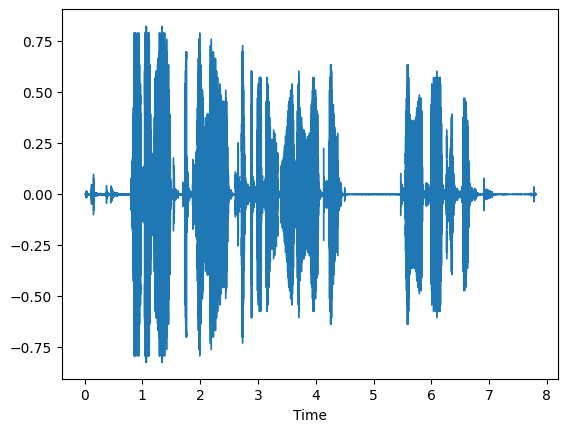

In [37]:
import librosa
import matplotlib.pyplot as plt
import librosa.display

array = minds[0]["audio"]["array"]
sampling_rate = minds[0]["audio"]["sampling_rate"]

librosa.display.waveshow(array,sr=sampling_rate)

In [38]:
from datasets import Audio

minds = minds.cast_column("audio",Audio(sampling_rate=16_000))

In [39]:
minds[0]

{'path': '/root/.cache/huggingface/datasets/downloads/extracted/a19fbc5032eacf25eab0097832db7b7f022b42104fbad6bd5765527704a428b9/en-AU~PAY_BILL/response_4.wav',
 'audio': {'path': '/root/.cache/huggingface/datasets/downloads/extracted/a19fbc5032eacf25eab0097832db7b7f022b42104fbad6bd5765527704a428b9/en-AU~PAY_BILL/response_4.wav',
  'array': array([2.36119668e-05, 1.92324660e-04, 2.19284790e-04, ...,
         9.40907281e-04, 1.16613181e-03, 7.20883254e-04]),
  'sampling_rate': 16000},
 'transcription': 'I would like to pay my electricity bill using my card can you please assist',
 'intent_class': 13}

In [40]:
from sys import path
max_duration = 20.0

def audio_in_range(input_length):
  return input_length < max_duration

new_column = [librosa.get_duration(path=x) for x in minds["path"]]
minds = minds.add_column("duration",new_column)

minds = minds.filter(audio_in_range,input_columns=["duration"])
minds = minds.remove_columns(["duration"])
minds

Filter:   0%|          | 0/654 [00:00<?, ? examples/s]

Dataset({
    features: ['path', 'audio', 'transcription', 'intent_class'],
    num_rows: 624
})

In [41]:
from transformers import WhisperFeatureExtractor

feature_extractor = WhisperFeatureExtractor.from_pretrained("openai/whisper-small")

def prepare_dataset(data):
  audio = data["audio"]
  features = feature_extractor(
      audio["array"],sampling_rate = audio["sampling_rate"],padding=True
  )
  return features

minds = minds.map(prepare_dataset)

Map:   0%|          | 0/624 [00:00<?, ? examples/s]

In [42]:
minds

Dataset({
    features: ['path', 'audio', 'transcription', 'intent_class', 'input_features'],
    num_rows: 624
})

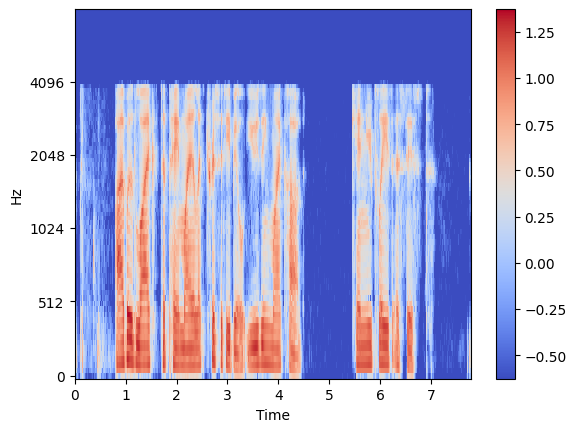

In [45]:
import numpy as np

example = minds[0]
input_features = example["input_features"]

librosa.display.specshow(
    np.asarray(input_features[0]),
    x_axis = "time",
    y_axis = "mel",
    sr = feature_extractor.sampling_rate,
    hop_length = feature_extractor.hop_length
)
plt.colorbar()

In [51]:
from huggingface_hub import login
login()

In [52]:
from datasets import load_dataset

gigaspeech = load_dataset("speechcolab/gigaspeech","xs",streaming=True,use_auth_token=True)

In [53]:
next(iter(gigaspeech['train']))

{'segment_id': 'YOU0000000315_S0000660',
 'speaker': 'N/A',
 'text': "AS THEY'RE LEAVING <COMMA> CAN KASH PULL ZAHRA ASIDE REALLY QUICKLY <QUESTIONMARK>",
 'audio': {'path': 'xs_chunks_0000/YOU0000000315_S0000660.wav',
  'array': array([0.0005188 , 0.00085449, 0.00012207, ..., 0.00125122, 0.00076294,
         0.00036621]),
  'sampling_rate': 16000},
 'begin_time': 2941.89,
 'end_time': 2945.07,
 'audio_id': 'YOU0000000315',
 'title': 'Return to Vasselheim | Critical Role: VOX MACHINA | Episode 43',
 'url': 'https://www.youtube.com/watch?v=zr2n1fLVasU',
 'source': 2,
 'category': 24,
 'original_full_path': 'audio/youtube/P0004/YOU0000000315.opus'}